# Script SSSee (InSPECtor)

### Python 3

**Florian Beyer**

**2019-02-22**

**Version 0.1**


SSSee ‚The Similar Spectra Seeker‘ is a tool to find similar spectra in a image dataset. It is a simple version of a one-class classifier. Only one threshold is necessary which the user has to play with (e.g. with an interactive slider). This method is a basic tool in Remote Sensing applications which is, as far as I know, not yet implemented in the EnMAP toolbox. 

## Sources:


[IMG1](https://www.researchgate.net/profile/Atef_Belhaj_Ali/publication/320616763/figure/fig2/AS:553386554687488@1508949044005/Concept-of-Spectral-Angle-Mapper-SAM.png)

[Equation](https://image.slidesharecdn.com/hypermulti-spectralimaging-091012113700-phpapp01/95/ati-professional-development-technical-training-short-course-sampler-on-hyper-multi-spectral-imaging-36-728.jpg?cb=1255347448)

[RSE paper](https://www.sciencedirect.com/science/article/pii/003442579390013N)

Maybe an improved idea??? -> [SCM](https://www.researchgate.net/publication/267721109_Spectral_Correlation_Mapper_SCM_An_Improvement_on_the_Spectral_Angle_Mapper_SAM)

### Required Packages

In [2]:
import rasterio
import rasterio.plot
import numpy as np


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

### Defining I/O parameters

In [15]:
# input image dataset
#ds = '/home/flo/Documents/Jupyter_notebooks/EnMAP_Box/Test_EnmapBox/subset_tif.tif'

ds = '/home/flo/Documents/2019_02_25_EnMAP_Workshop/Data/enmap_tiff.tif'

#define reference pixel
#ref_pixel = [66,100] # water (0.5)
ref_pixel = [195,25] # vital vegetation (T = 0.2)
#ref_pixel = [270,300] # dryvegetation (0.1)


# define a threshold
threshold = 0.4

# save path
save_path = '/home/flo/Documents/Jupyter_notebooks/EnMAP_Box/'

### Load Data and plot the image and the reference spectrum

The dataset has 177 bands


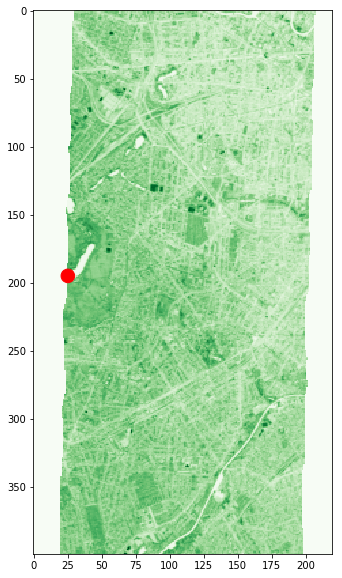

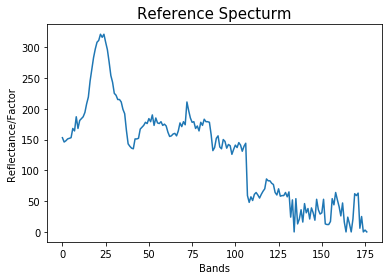

In [13]:
# load image data
img_ds = rasterio.open(ds) 
print('The dataset has {} bands'.format(img_ds.count))

# read all bands
bands = []
for i in range(img_ds.count):
    temp = img_ds.read(i+1)
    temp = temp.astype('f4')
    bands.append(temp)
    temp = None

# convert the bands stack to an 3D Numpy array
bands_np = np.array(bands)
bands = None # delete bands list

# Plot first band of the image add a red circle for the location of the reference pixel
fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(bands_np[67,:,:], cmap='Greens')
ax.add_patch(Circle((ref_pixel[1],ref_pixel[0]), radius=5,color='red'))
plt.show(fig)

# load reference spectra
plt.plot(bands_np[:,ref_pixel[0],ref_pixel[1]])
plt.title('Reference Specturm', fontsize=15)
plt.xlabel('Bands')
plt.ylabel('Reflectance/Factor')
plt.show()

### SSSee Functions

In [29]:
def SSSee(image, reference):
    # gernate a 3D np.array with the same extent as 
    ref = image[:,reference[0],reference[1]]
    r_ = np.ones(image.shape)
    for i in range(bands_np.shape[1]):
        for j in range(bands_np.shape[2]):
            r_[:,i,j] = ref
    
    #------- this is the equation
    # a = cos^-1( sqrt(sum(t*r)) / (sqrt(sum(t^2)) * sqrt(sum(r^2)) ))
    sum_zaehler = np.sum(r_*image, axis=0)
    
    ref_square = np.sum(r_**2, axis=0)
    tar_square = np.sum(image**2, axis=0)
    
    ref_sqrt = np.sqrt(ref_square)
    tar_sqrt = np.sqrt(tar_square) 
    
    sssee = np.arccos(sum_zaehler/(ref_sqrt*tar_sqrt))
    #-------
    
    # replace nan's with 0
    sssee[np.isnan(sssee)] = 0
    
    return [sssee,sum_zaehler,r_,image,ref_square,tar_square,ref_sqrt,tar_sqrt]

def SSSee_mask(sssee_map, threshold):
    # masks all SSSee Values to binary mask with 0 and 1
    mask = np.copy(sssee_map)
    mask[sssee_map > threshold] = 0
    mask[sssee_map <= threshold] = 1
    mask = mask.astype(np.int16)
    
    return mask

245443620.0


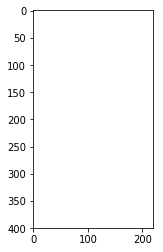

In [36]:
plt.imshow(test[4], cmap='binary')

print(test[5][100,100])

###  Calculate and plot the SSSee map and the SSSee mask

In [18]:
# calculate SSSee map
test = SSSee(bands_np, ref_pixel)

# calculate SSSee mask
mask = SSSee_mask(test, threshold)

# plot SSSee map
plt.figure(figsize = (15,5))
plt.imshow(test,cmap='Spectral')
plt.colorbar()
plt.title('SSSee map', fontsize=15)
plt.text(test.shape[1]+test.shape[1]/3, 0.5*test.shape[0], 'The redder the closer to the target class!', fontsize=20)
plt.show()

# plot SSSee mask
plt.figure(figsize=(15,5))
plt.imshow(mask, cmap='gray')
plt.title('SSSee mask with a threshold of '+str(threshold), fontsize=15)
plt.text(test.shape[1]+test.shape[1]/3, 0.5*test.shape[0], 'White areas show the target class.', fontsize=20)
plt.show()

/home/flo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in arccos


TypeError: '>' not supported between instances of 'list' and 'float'

### Save map and mask in the chosen directory

In [22]:
#map
with rasterio.open(ds) as src:
    profile = src.profile.copy()
    profile.update({
        # all meta data are the same except the bands number
        'count': 1, # this is the important update from n bands to one band
        'dtype': 'float64'
    })

filename = save_path+'SSSee_MAP_'+'row'+str(ref_pixel[0])+'col'+str(ref_pixel[1])+'.tif'
with rasterio.open(filename, 'w', **profile) as dst:
    dst.write_band(1,test)
    
#mask    
with rasterio.open(ds) as src:
    profile = src.profile.copy()
    profile.update({
        # all meta data are the same except the bands number
        'count': 1, # this is the important update from n bands to one band
        'dtype': 'int16'
    })
    
filename = save_path+'SSSee_MASK_'+'row'+str(ref_pixel[0])+'col'+str(ref_pixel[1])+ 'Threshold'+ str(threshold) + '.tif'
with rasterio.open(filename, 'w', **profile) as dst:
    dst.write_band(1,mask)

# End

In [ ]:
def scm_map(image, reference):
    # gernate a 3D np.array with the same extent as 
    ref = image[:,reference[0],reference[1]]
    r_ = np.ones(image.shape)
    for i in range(bands_np.shape[1]):
        for j in range(bands_np.shape[2]):
            r_[:,i,j] = ref
    
    #------this is theequation
    # sum( ( T-avT )*( R-avR ) ) / sqrt( ( sum(T-avT)² ) * ( sum(R-avR)² ) )

    zaehler = np.sum(((image-np.mean(image,axis=0))*(r_-np.mean(r_,axis=0))), axis=0)
    
    
    nen1 = np.sum((image - np.mean(image, axis=0))**2 , axis=0)
    nen2 = np.sum( image - np.mean(image, axis=0) , axis=0)
    nenner = np.sum( np.sqrt((image - np.mean(image, axis=0))**2) * np.sqrt((r_ - np.mean(r_, axis=0))**2) , axis=0)
    
    scm = zaehler/nenner
    
    return [scm,zaehler,nen1,nen2,nenner]   
